# Load libraries

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from joblib import load
from treeinterpreter import treeinterpreter as ti
from sklearn.inspection import permutation_importance
import pandas as pd

# Define general variables

In [2]:
seed = 0
only_these_labels = [16, 92, 53, 88, 65, 6] 
number_experiment = 17

# Get own model predictions

In [3]:
# load model
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
ownModelResults = pickle.load(a_file)
print(ownModelResults.keys())
print(ownModelResults["trainIds"].shape)

dict_keys(['trainIds', 'trainLabels', 'trainPredictions', 'validIds', 'validLabels', 'validPredictions', 'testIds', 'testLabels', 'testPredictions'])
(52360,)


# Get RF predictions

In [8]:
# load files
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/RF/predictionsRF.pkl", "rb")
rFResults = pickle.load(a_file)
print(rFResults.keys())
print(rFResults["testPredictions"].shape)

dict_keys(['trainIds', 'trainLabels', 'trainPredictions', 'validIds', 'validLabels', 'validPredictions', 'testIds', 'testLabels', 'testPredictions'])
(6546,)


# Test if test datasets are equals

In [9]:
assert np.array_equal(ownModelResults["testIds"], rFResults["testIds"])
print("test ok: ids in train dataset used in own model are the same in RF")

test ok: ids in train dataset used in own model are the same in RF


In [10]:
assert np.array_equal(ownModelResults["testLabels"], rFResults["testLabels"])
print("test ok: labels in train dataset used in own model are the same in RF")

test ok: labels in train dataset used in own model are the same in RF


In [11]:
assert not np.array_equal(ownModelResults["testPredictions"], rFResults["testPredictions"])
print("test ok: predictions of own model and RF are differente in test")

test ok: predictions of own model and RF are differente in test


# Analysis

# get confusion matrix

In [36]:
# ["true", "pred", "all", None]
normalize = "true"

RF model


<AxesSubplot:>

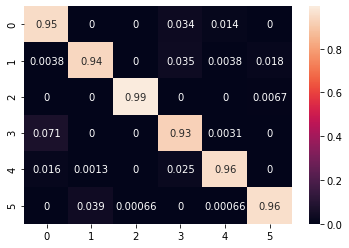

In [37]:
print("RF model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
rFResultsCM = confusion_matrix(
    rFResults["testLabels"], 
    rFResults["testPredictions"], 
    normalize = normalize
)

# print(f"class 0: {rFResultsCM[0, :]}")

# plot
sn.heatmap(rFResultsCM, annot=True)

Own model
class 0: [0.72413793 0.04827586 0.06896552 0.06206897 0.07586207 0.02068966]


<AxesSubplot:>

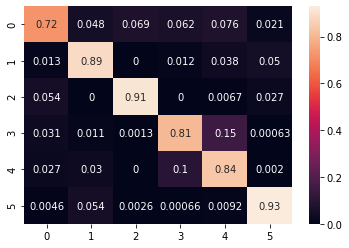

In [38]:
print("Own model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
ownModelCM = confusion_matrix(ownModelResults["testLabels"], ownModelResults["testPredictions"], normalize = normalize)

print(f"class 0: {ownModelCM[0, :]}")

# plot
sn.heatmap(ownModelCM, annot=True)

# Get classification report

In [40]:
print("RF model")
print(classification_report(rFResults["testLabels"], rFResults["testPredictions"]))

RF model
              precision    recall  f1-score   support

         6.0       0.49      0.95      0.65       145
        16.0       0.96      0.94      0.95      1593
        53.0       0.99      0.99      0.99       149
        65.0       0.94      0.93      0.93      1598
        88.0       0.99      0.96      0.97      1537
        92.0       0.98      0.96      0.97      1524

    accuracy                           0.95      6546
   macro avg       0.89      0.95      0.91      6546
weighted avg       0.96      0.95      0.95      6546



In [41]:
print("own model")
print(classification_report(ownModelResults["testLabels"], ownModelResults["testPredictions"]))

own model
              precision    recall  f1-score   support

         6.0       0.45      0.72      0.56       145
        16.0       0.90      0.89      0.90      1593
        53.0       0.89      0.91      0.90       149
        65.0       0.88      0.81      0.84      1598
        88.0       0.80      0.84      0.82      1537
        92.0       0.94      0.93      0.93      1524

    accuracy                           0.86      6546
   macro avg       0.81      0.85      0.83      6546
weighted avg       0.87      0.86      0.87      6546



# Get how many correct and wrong classifications are done by each model?
Add this to the paper

In [42]:

# save correct classifications by each model 
# shape: (classes, models (2: own and RF))
correctClassifications = np.zeros(shape  = (6, 2))

wrongClassifications = np.zeros(shape = (6,2))

# iterate by each class
for i in np.arange(6):
    
    # RF
    correctClassifications[i][0] = rFResultsCM[i][i] / np.sum(rFResultsCM[i])
    wrongClassifications[i][0] = np.sum(rFResultsCM[i][np.delete(np.arange(6), i)]) / np.sum(rFResultsCM[i])
    
    # own model
    correctClassifications[i][1] = ownModelCM[i][i] / np.sum(ownModelCM[i])
    wrongClassifications[i][1] = np.sum(ownModelCM[i][np.delete(np.arange(6), i)]) / np.sum(ownModelCM[i])

In [44]:
print("Correct classifications. 0: RF")
correctClassifications

Correct classifications. 0: RF


array([[0.95172414, 0.72413793],
       [0.9391086 , 0.88826114],
       [0.99328859, 0.91275168],
       [0.9261577 , 0.80851064],
       [0.95770982, 0.84059857],
       [0.95931759, 0.92913386]])

In all classes, RF is better

In [45]:
print("Wrong classifications. 0: RF")
wrongClassifications

Wrong classifications. 0: RF


array([[0.04827586, 0.27586207],
       [0.0608914 , 0.11173886],
       [0.00671141, 0.08724832],
       [0.0738423 , 0.19148936],
       [0.04229018, 0.15940143],
       [0.04068241, 0.07086614]])

In all classes, RF is better

Based on resutls, RF is better in all classes. There is no one class our model is better, so the models are not complementaries. Our model does not add more value to the classification.

# Get examples wrongly classified by own model but correctly by RF

In [46]:
# get RF samples who predictions are equals to labels
maskRFCorrects = (rFResults["testPredictions"] == ownModelResults["testLabels"])

# get OM samples who predictions are not equals to labels
maskOwnModelWrong = (ownModelResults["testPredictions"] != ownModelResults["testLabels"])

# get ids that 1)RF are corrects 2) ON are wrong
finalMask = (maskRFCorrects & maskOwnModelWrong)

# get ids samples
idsRFCorrectsAndOwnModelWrongs = ownModelResults["testIds"][finalMask]
labelsRFCorrectsAndOwnModelWrongs = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

In [47]:
idsRFCorrectsAndOwnModelWrongs.shape

(740,)

In [48]:
# test if RF is correct classified and Own model is wrong
for i in idsRFCorrectsAndOwnModelWrongs:
    
    index = np.where(ownModelResults["testIds"]  == i)[0][0]
    
    # test
    # 1) if RF is classifiying correctly
    # 2) if Own model is classifiying wrongly
    assert ownModelResults["testLabels"][index] == rFResults["testPredictions"][index] and ownModelResults["testLabels"][index] != ownModelResults["testPredictions"][index]

Text(0.5, 1.0, 'Samples correct RF and wrong own model')

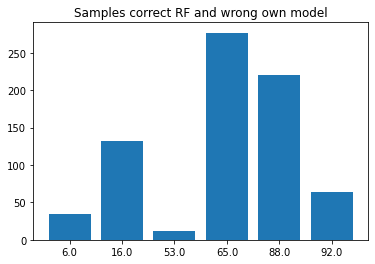

In [49]:
# analyze labels distributions
fig, ax = plt.subplots()

classes, countClasses = np.unique(labelsRFCorrectsAndOwnModelWrongs, return_counts = True)

# countClasses = countClasses / np.sum(countClasses)
countClasses = countClasses

classes = list(map(str, classes))

ax.bar(
    classes, 
    countClasses,
#     width = 10,
)

ax.set_title("Samples correct RF and wrong own model")

# Get examples correctly classified by own model but wrongly by RF

In [50]:
# get RF samples who predictions are equals to labels
maskRFWrong = (rFResults["testPredictions"] != ownModelResults["testLabels"])

# get OM samples who predictions are not equals to labels
maskOwnModelCorrect = (ownModelResults["testPredictions"] == ownModelResults["testLabels"])

# get ids that 1)RF are corrects 2) ON are wrong
finalMask = (maskRFWrong & maskOwnModelCorrect)

# get ids samples
idsRFWrongAndOwnModelCorrect = ownModelResults["testIds"][finalMask]
labelsRFWrongsAndOwnModelCorrects = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

Text(0.5, 1.0, 'Samples wrong RF and correct own model')

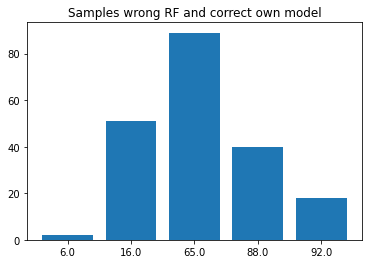

In [51]:
# analyze labels distributions
fig, ax = plt.subplots()

classes, countClasses = np.unique(labelsRFWrongsAndOwnModelCorrects, return_counts = True)

# countClasses = countClasses / np.sum(countClasses)
countClasses = countClasses 

classes = list(map(str, classes))

ax.bar(
    classes, 
    countClasses,
#     width = 10,
)

ax.set_title("Samples wrong RF and correct own model")

# Get features RF uses to classify them

In [25]:
# # get RF model
# # # load file
# rf = load('../../experiments/comparingModels/seed' + str(seed) + '/RF/trainedRF.joblib') 

In [26]:
# # loading features names
# seed = 0
# with open(f"../random_forest/ids/seed{seed}/maxClass15k/dataset_ids_before_balancing.pkl", "rb") as f:
#     lc_ids = pickle.load(f)

# with open("../random_forest/features/fats"+str(int(lc_ids["train"][0]))+".pkl", "rb") as f:
#     tmp = load(f)
    
#     # get features names
#     featuresNames = tmp.columns.values

In [22]:
# # FATS computing: https://github.com/isadoranun/FATS/blob/master/FATS/FeatureFunctionLib.py

# # get the most important features
# featuresByImportance, importance = featuresNames[np.argsort(rf.feature_importances_)[::-1]], rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1]]

# featuresToDisplay = 20

# fig, ax = plt.subplots(figsize = (10, 10), tight_layout = True)

# ax.set_title(f"Top {featuresToDisplay} feature importances on Random Forest")
# ax.barh(featuresByImportance[:featuresToDisplay], importance[:featuresToDisplay])
# # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
# ax.set_yticklabels(featuresByImportance[:featuresToDisplay],fontsize=10, rotation=45)

# Get decomposition of predictions on correct RF and wrong OM

In [28]:
# # (node_indicator, _) = rf.decision_path(instances)

# # node_indicator

# # Extract single tree
# estimator = rf.estimators_
# estimatorIndex = 0
# print(f"number of trees: {len(estimator)}")

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator[estimatorIndex], 
#                 out_file='tree' + str(estimatorIndex) + '.dot', 
#                 feature_names = featuresNames,
#                 class_names = True,
#                 rounded = True, 
#                 proportion = False, 
#                 precision = 2, 
#                 filled = True,
#                 rotate = True,
# )

# # Convert to png
# estimatorIndex = str(estimatorIndex)
# from subprocess import call
# call(['dot', '-Tpng', 'tree' + estimatorIndex + '.dot', '-o', 'tree'  + estimatorIndex + '.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree' + estimatorIndex + '.png')

In [23]:
# # get data
# id_ = idsRFCorrectsAndOwnModelWrongs[1]

# index = np.where(ownModelResults["testIds"]  == id_)[0][0]

# print(f"label: {ownModelResults['testLabels'][index]}")

# print(f"RF prediction: {rFResults['testPredictions'][index]}")

# with open("../random_forest/features/fats"+ str(round(id_)) +".pkl", "rb") as f:
#     instances = load(f)

# #get predictions
# prediction, bias, contributions = ti.predict(rf, instances)

# # prediction = rf.predict(instances)

# only_these_labels = [16, 92, 53, 88, 65, 6]

# print(only_these_labels[np.argmax(prediction)])

In [30]:
# print(prediction)

# print(np.argmax(prediction))

[[0.20052328 0.09406491 0.00284883 0.02324763 0.670528   0.00878735]]
4


In [24]:
# # get decomposition
# for i in range(len(instances)):
    
#     print("Instance", i)
#     print("Bias (trainset mean", bias[i])
#     print("Feature contributions:")
# #     for c, feature in sorted(zip(contributions[i], featuresNames), key=lambda x: -abs(x[0])):
# #         print(feature, round(c, 2))
#     for c, feature in zip(contributions[0], 
#                              featuresNames):
#         print(feature)
#         print(c)
        
#     print("-"*20)

In [32]:
# ti.predict?

# Feature importance permutation analysis

In [52]:
# get RF model
# # load file
rf = load('../../experiments/comparingModels/seed' + str(seed) + '/RF/trainedRF.joblib') 

In [53]:
# loading features names
seed = 0
with open(f"../random_forest/ids/seed{seed}/maxClass15k/dataset_ids_before_balancing.pkl", "rb") as f:
    lc_ids = pickle.load(f)

with open("../random_forest/features/fats"+str(int(lc_ids["train"][0]))+".pkl", "rb") as f:
    tmp = load(f)
    
    # get features names
    featuresNames = tmp.columns.values

# by classes

In [54]:
idsRFCorrectsAndOwnModelWrongs.shape

(740,)

In [55]:
# get features
features = {}
labels = {}

# get ids to analyze

# get all classes
classesToAnalyze = only_these_labels

for classToAnalyze in classesToAnalyze:
    
    # 1) ids with RF correct and RF wrong
    selectedIds = idsRFCorrectsAndOwnModelWrongs[labelsRFCorrectsAndOwnModelWrongs == classToAnalyze]
    
    tmp = []
    
    # get data
    for lc_id in selectedIds:

        with open("../random_forest/features/fats"+str(int(lc_id))+".pkl", "rb") as f:
            tmp.append(load(f))

    tmp = np.array(tmp, dtype = "float").reshape(len(tmp),-1)
    
    # clean data
    
    # get rows without inf values
    mask = ~(np.isinf(tmp).any(axis=1))

    mask2 = ~(np.isnan(tmp).any(axis = 1))

    # print(mask2.shape)
    # print(mask.shape)

    features_ = tmp[mask & mask2]
    labels_ = labelsRFCorrectsAndOwnModelWrongs[labelsRFCorrectsAndOwnModelWrongs == classToAnalyze][mask & mask2]

    print(features_.shape)
    print(labels_.shape)


    # transform list into array
    features[classToAnalyze] = features_
    labels[classToAnalyze] = labels_

(126, 288)
(126,)
(55, 288)
(55,)
(11, 288)
(11,)
(209, 288)
(209,)
(273, 288)
(273,)
(33, 288)
(33,)


In [ ]:
# save permutation by class
permutationImportancesClasses = {}

for classToAnalyze in classesToAnalyze:
    
    print(f"class: {classToAnalyze}")
    print(f"features: {labels[classToAnalyze].shape}")
    
    # get permutation importances
    r = permutation_importance(
                        rf, 
                        features[classToAnalyze], 
                        labels[classToAnalyze],
                        n_repeats=10,
                        random_state=0,
                        n_jobs = 4,
    )
    
    # save permutation by class
    permutationImportancesClasses[classToAnalyze] = r

In [ ]:
# # save file
# a_file = open("./importancePermutationTestByClass.pkl", "wb")
# pickle.dump(permutationImportancesClasses, a_file)
# a_file.close()

In [57]:
# save permutations results
# save object
a_file = open("./importancePermutationTestByClass.pkl", "rb")
permutationImportancesClasses = pickle.load(a_file)

In [58]:
# a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/testOwnModelPredictions.pkl", "rb")
# ownModelResults = pickle.load(a_file)

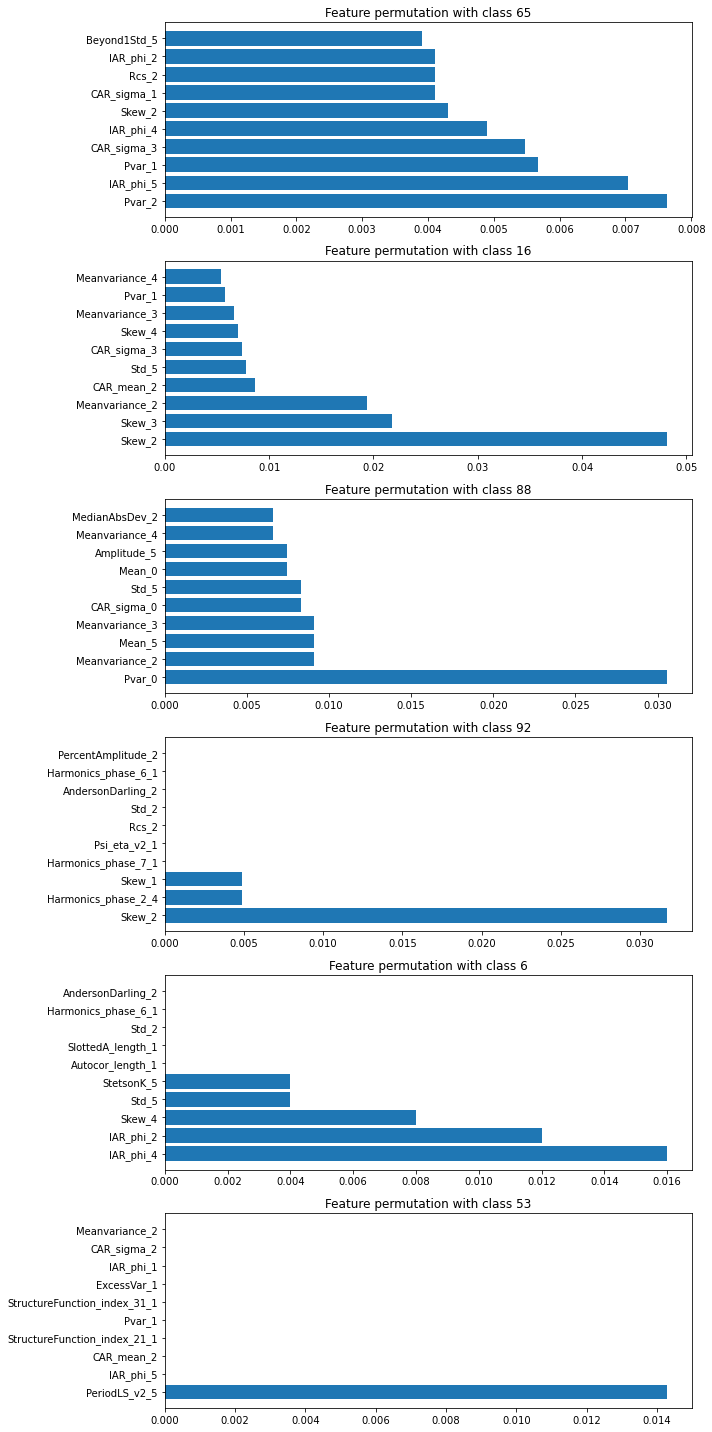

In [59]:
# do plot
fig, ax = plt.subplots(len(classesToAnalyze), 1, figsize = (10, 20), tight_layout = True)

maxIndex = 10

classesToAnalyze = [65, 16, 88, 92, 6, 53]

# each class
for i, class_ in enumerate(classesToAnalyze):
    
    # get sorted feautres
    idxFeatures = permutationImportancesClasses[class_].importances_mean.argsort()[::-1][:maxIndex]
    
#     print(idxFeatures.shape)
#     print(permutationImportancesClasses[class_].importances_mean[idxFeatures])
    
    ax[i].set_title(f"Feature permutation with class {class_}")
    ax[i].barh(
        featuresNames[idxFeatures], 
        permutationImportancesClasses[class_].importances_mean[idxFeatures],
    )
#     # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
#     ax[i].set_yticklabels(featuresNames[:maxIndex],fontsize=10, rotation=45)


# full dataset

In [68]:
# 1) ids with RF correct and RF wrong
features_ = []

# get data
for lc_id in idsRFCorrectsAndOwnModelWrongs:

    with open("../random_forest/features/fats"+str(int(lc_id))+".pkl", "rb") as f:
        features_.append(load(f))

features_ = np.array(features_, dtype = "float").reshape(len(features_),-1)

# print(features_.shape)

# clean data

# get rows without inf values
mask = ~(np.isinf(features_).any(axis=1))

mask2 = ~(np.isnan(features_).any(axis = 1))

# print(mask2.shape)
# print(mask.shape)

features = features_[mask & mask2]
labels = labelsRFCorrectsAndOwnModelWrongs[mask & mask2]

print(features.shape)
print(labels.shape)

(948, 288)
(948,)


In [69]:
 # get permutation importances
r = permutation_importance(
                    rf, 
                    features, 
                    labels,
                    n_repeats=10,
                    random_state=0,
                    n_jobs = 4,
)

# save file
a_file = open("./importancePermutationTestAllClasses.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

<BarContainer object of 10 artists>

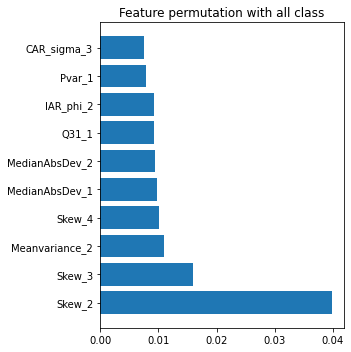

In [70]:
# do plot
fig, ax = plt.subplots(figsize = (5, 5), tight_layout = True)

maxIndex = 10

# get sorted feautres
idxFeatures = r.importances_mean.argsort()[::-1][:maxIndex]

ax.set_title(f"Feature permutation with all class")
ax.barh(
    featuresNames[idxFeatures], 
    r.importances_mean[idxFeatures],
)
#     # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
#     ax[i].set_yticklabels(featuresNames[:maxIndex],fontsize=10, rotation=45)


# Analizing what model is the best one

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

18
acc: 0.87 +/- 0.02
f1 macro: 0.83 +/- 0.01
f1 weighted: 0.87 +/- 0.02 
f1 macro:
[16, 92, 53, 88, 65, 6]
[0.89 0.93 0.93 0.84 0.85 0.54]
[0.012 0.005 0.011 0.025 0.028 0.024]
19
acc: 0.86 +/- 0.01
f1 macro: 0.82 +/- 0.01
f1 weighted: 0.86 +/- 0.01 
f1 macro:
[16, 92, 53, 88, 65, 6]
[0.89 0.95 0.94 0.84 0.81 0.47]
[0.019 0.008 0.01  0.006 0.014 0.019]


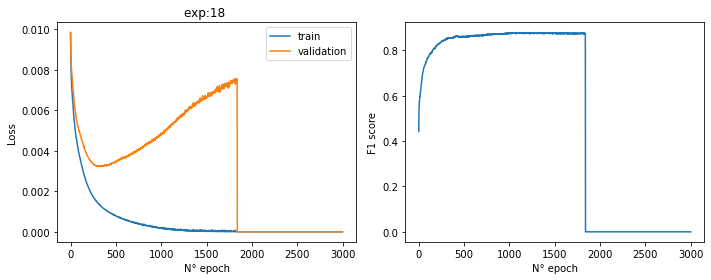

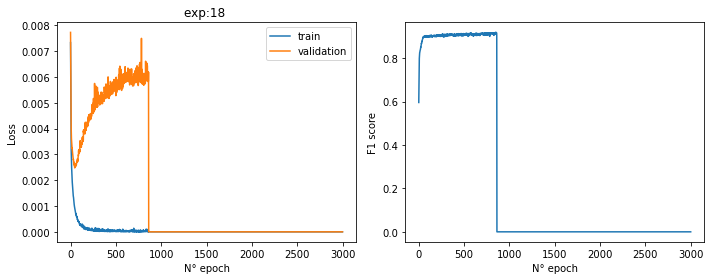

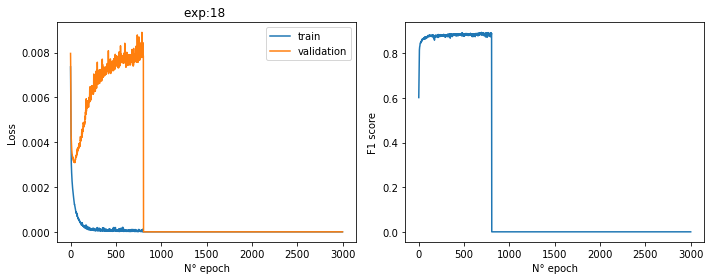

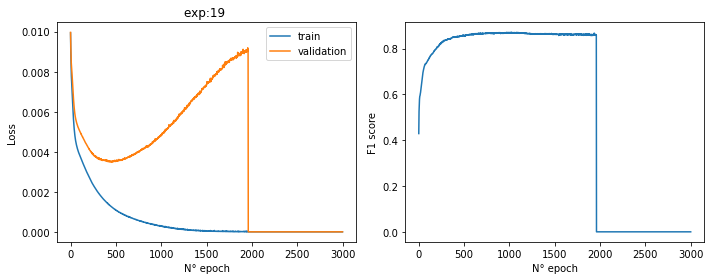

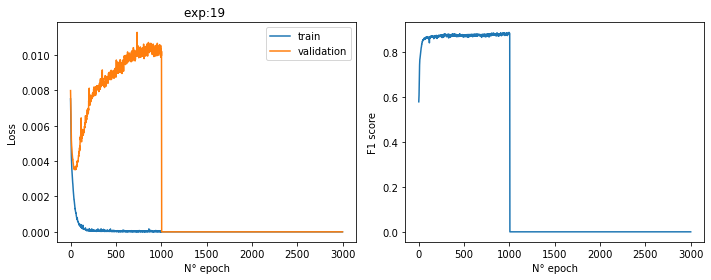

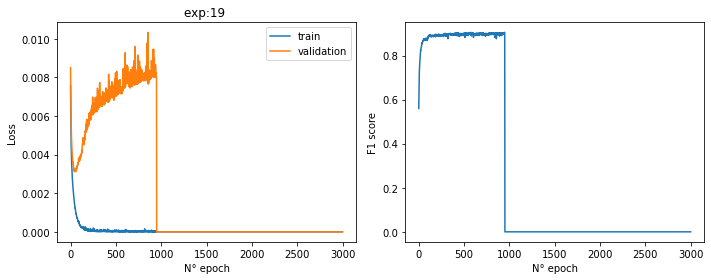

In [34]:
# modelsToAnalize = [17, 18, 19, 20]
modelsToAnalize = [18, 19]
seeds = [0, 1, 2]


tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"
max_elements_per_class = 15000

for number_experiment in modelsToAnalize:
    
#     accTmp = 0
#     f1Macro = 0
#     f1Weighted = 0
    
    accArray = np.zeros(shape = (len(seeds), ))
    f1MacroArray = np.zeros(shape = (len(seeds), ))
    f1WeightedArray = np.zeros(shape = (len(seeds), ))

    f1Array = np.zeros(shape = (len(seeds), len(only_these_labels), ))
    
    print(number_experiment)
    
    for seed in seeds:
        
#         print(f"{number_experiment} + seed + {seed}")

        # path to load data
        expPath = "experiments/" + str(number_experiment) + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"
        folder_path = (tmpLocal + expPath)

        
        ######## plot training loss and f1 score

        losses = pd.read_csv(folder_path + "/training_losses.csv")

        # f1 scores
        # f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
        f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

        # plot losses
        fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

        maxPlot = 3000

        # loss
        ax[0].set_xlabel("N° epoch")
        ax[0].set_ylabel("Loss")
        ax[0].plot(losses.iloc[:maxPlot, 0], label = "train")
        ax[0].plot(losses.iloc[:maxPlot, 1], label = "validation")
        ax[0].legend()
        ax[0].set_title(f"exp:{number_experiment} ")

        # f1 scores
        ax[1].set_xlabel("N° epoch")
        ax[1].set_ylabel("F1 score")
        ax[1].plot(f1Scores.iloc[:maxPlot])
        
        
        
         ############ get classification report

        a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
        ownModelResultsTmp = pickle.load(a_file)

#         print(classification_report(
#             ownModelResultsTmp["testLabels"], 
#             ownModelResultsTmp["testPredictions"],
#             labels = only_these_labels,
#         ))

        # to compute mean accuracy (by seeds)
        accArray[seed] = accuracy_score(
            ownModelResultsTmp["validLabels"], 
            ownModelResultsTmp["validPredictions"]
        )
        
        f1MacroArray[seed] = f1_score(
            ownModelResultsTmp["validLabels"], 
            ownModelResultsTmp["validPredictions"], 
            average='macro'
        )
        
        f1Array[seed, :] = f1_score(
            ownModelResultsTmp["validLabels"], 
            ownModelResultsTmp["validPredictions"], 
            average=None,
            labels = only_these_labels,
        )
        
        
        f1WeightedArray[seed] += f1_score(
            ownModelResultsTmp["validLabels"], 
            ownModelResultsTmp["validPredictions"], 
            average='weighted'
        )
        
    print(f"acc: {np.mean(accArray):.2f} +/- {np.std(accArray):.2f}")
    
    print(f"f1 macro: {np.mean(f1MacroArray):.2f} +/- {np.std(f1MacroArray):.2f}")
    
    print(f"f1 weighted: {np.mean(f1WeightedArray):.2f} +/- {np.std(f1WeightedArray):.2f} ")
    
    print("f1 macro:")
    print(only_these_labels)
    print(np.around(np.mean(f1Array, axis = 0) , 2))
    print(np.around(np.std(f1Array, axis = 0) , 3))
    
#     print("\n")

In [15]:
# 18
acc = (0.86 + 0.89 + 0.87)/3

print(acc)

0.8733333333333334


# Get metrics own model and RF on train, validation and test

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

subsets = ["train", "valid", "test"]

for subset in subsets:
    
    print(subset)
    
    # get accuracy
    accuracyRF = accuracy_score(
        rFResults[subset + "Labels"], 
        rFResults[subset + "Predictions"]
    )
    
    
    accuracyOwnModel = accuracy_score(
        ownModelResults[subset + "Labels"], 
        ownModelResults[subset + "Predictions"]
    )
    

    print(f"RF accuracy: {accuracyRF:.2f}")
    print(f"own model accuracy: {accuracyOwnModel:.2f}")

    # get f1 score
    f1OwnModelMacro = f1_score(
        ownModelResults[subset + "Labels"], 
        ownModelResults[subset + "Predictions"], 
        average='macro'
    )
    
    f1RFMacro = f1_score(
        rFResults[subset + "Labels"], 
        rFResults[subset + "Predictions"], 
        average='macro'
    )
    
    f1OwnModelWeighted = f1_score(
        ownModelResults[subset + "Labels"], 
        ownModelResults[subset + "Predictions"], 
        average='weighted'
    )
    
    f1RFWeighted = f1_score(
        rFResults[subset + "Labels"], 
        rFResults[subset + "Predictions"], 
        average='weighted'
    )
    
    print(f"RF f1 macro: {f1RFMacro:.2f}")
    print(f"own model f1 macro: {f1OwnModelMacro:.2f}")
    
    print(f"RF f1 weighted: {f1RFWeighted:.2f}")
    print(f"own model f1 weighted: {f1OwnModelWeighted:.2f}")
    
    
    print("\n")
# f1 macro

# f1 weighted

train
RF accuracy: 0.96
own model accuracy: 0.83
RF f1 macro: 0.92
own model f1 macro: 0.83
RF f1 weighted: 0.96
own model f1 weighted: 0.83


valid
RF accuracy: 0.94
own model accuracy: 0.68
RF f1 macro: 0.90
own model f1 macro: 0.64
RF f1 weighted: 0.94
own model f1 weighted: 0.71


test
RF accuracy: 0.95
own model accuracy: 0.71
RF f1 macro: 0.91
own model f1 macro: 0.65
RF f1 weighted: 0.95
own model f1 weighted: 0.70




# f1 scores by class

In [14]:
print("RF f1:")
f1_score(
    rFResults["testLabels"], 
    rFResults["testPredictions"],
    average = None,
)

RF f1:


array([0.64637002, 0.94953983, 0.99328859, 0.93169657, 0.97386702,
       0.96949602])

In [22]:
print("Own model f1:")
f1_score(
    ownModelResults["testLabels"], 
    ownModelResults["testPredictions"],
#     average = None,
    average = "macro"
)

Own model f1:


0.6462574161286242

In [20]:
print("RF model")
print(classification_report(rFResults["testLabels"], rFResults["testPredictions"]))

RF model
              precision    recall  f1-score   support

         6.0       0.49      0.95      0.65       145
        16.0       0.96      0.94      0.95      1593
        53.0       0.99      0.99      0.99       149
        65.0       0.94      0.93      0.93      1598
        88.0       0.99      0.96      0.97      1537
        92.0       0.98      0.96      0.97      1524

    accuracy                           0.95      6546
   macro avg       0.89      0.95      0.91      6546
weighted avg       0.96      0.95      0.95      6546



In [21]:
print("own model")
print(classification_report(ownModelResults["testLabels"], ownModelResults["testPredictions"]))

own model
              precision    recall  f1-score   support

         6.0       0.23      0.72      0.35       145
        16.0       0.90      0.76      0.82      1593
        53.0       0.56      0.99      0.72       149
        65.0       0.56      0.92      0.69      1598
        88.0       0.85      0.23      0.36      1537
        92.0       0.96      0.91      0.93      1524

    accuracy                           0.71      6546
   macro avg       0.68      0.75      0.65      6546
weighted avg       0.80      0.71      0.70      6546

